## Computing Edge Shading

도형의 기본 색을 $C$라 하고, 각 픽셀별 색의 강도를 $h$ 를 통해 조절한다. 

$C_h = (R_C \cdot h, G_C \cdot h, B_C \cdot h)$

따라서 $h = 0.0$ 인 구역은 검정색으로 표현되고, $h = 1.0$ 이면 $C$의 색으로, $h = 0.5$ 인 경우 중간 밝기를 가진다.   


그림자가 진 삼각형을 그리기 위해서는, 삼각형의 각 픽셀별 $h$ 를 계산한 후 각 색의 그림자를 계산하고 픽셀을 칠하면 된다.   

삼각형 꼭짓점의 값을 $h$ 로 정한 후 어떻게 삼각형의 다른 부분의 h 값을 계산할 수 있을까?    

삼각형 변의 값부터 시작한다. $AB$ 를 생각해보자. 우리는 꼭짓점인 $h_A , h_B$ 의 값을 알고 있다.      
과연 $AB$ 의 중간 지점인 $M$ 에선 어떤 일이 일어날까? 우리는 $A$ 에서 $B$ 까지 부드러운 강도를 주고 싶기 때문에, $h_M$은  $h_A , h_B$의 중간에 존재 할 것이고, $M$이 $AB$의 중심이기 대문에 $h_M$ 은  $h_A , h_B$의 평균일 것이다. 

우리는 $P$ 값을 입력하면 빛의 세기인 $h$ 를 얻는 $h = f(P)$ 수식을 지닌다. $A, B$ 는 $h(A) = h_A, h(B) = h_B$ 와 같은 값을 가진다. 우리는 함수가 부드럽길 원하기 때문에, 선형 함수와 같은 호환가능한 다양한 함수를 선택할 수 있다.   
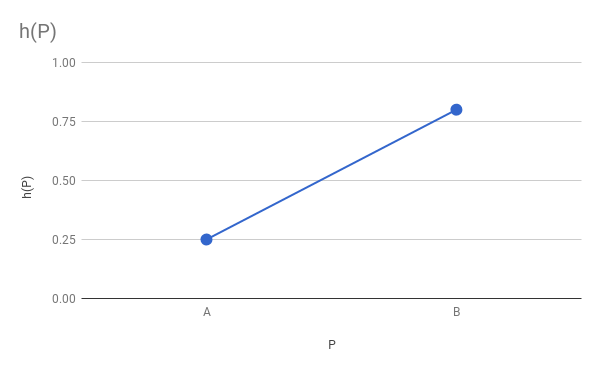

우리는 위에서 했던 `interpolate` 를 이용하여 $h$ 값을 계산할 수 있다. y를 독립변수(우리가 알고있는 값)로 두고, h를 종속변수(우리가 알고싶은 값)로 둔 다음 `interpolate` 함수를 이용하여 계산한다.    

또한 짧은 부분의 열을 합친 후에 x02와 x012를 비교하여 어느 쪽이 왼쪽인지 오른쪽인지를 결정한다. 우리는 어느값이 왼쪽인지를 결정하기 위해 항상 같은 x를 사용하기 때문에 $h$의 경우 이미 정해놓은 결과를 따르기만 하면 된다. 

```java
//pseudo code
x01 = Interpolate(y0, x0, y1, x1)
h01 = Interpolate(y0, h0, y1, h1)
x12 = Interpolate(y1, x1, y2, x2)
h12 = Interpolate(y1, h1, y2, h2)
x02 = Interpolate(y0, x0, y2, x2)
h02 = Interpolate(y0, h0, y2, h2)

//Concatenate the short sides
remove_last(x01)
x012 = x01 + x12

remove_last(h01)
h012 = h01 + h12

//Determine which is left and which is right

m = floor(x012.length / 2)
if x02[m] < x012[m] {
    x_left = x02
    h_left = h02
    x_right = x012
    h_right = h012
} 
else {
    x_left = x012
    h_left = h012
    x_right = x02
    h_right = h02
}
``` 

In [6]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [29]:
class Point:
    def __init__(self, x, y, h, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color

class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        
    def draw_line(self, p0, p1, color, line_width):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                self.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                self.put_pixel(xs[i], i+p0.y, color, line_width)
                
    
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i1 - i0+1):
                values.append(d)
                d += a
            return values
        
    def draw_wire_triangle(self, p0, p1, p2, color, line_width):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p0, p2, color, line_width)
        
    def draw_filled_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
        
        # Compute the x coordinates of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            x_right= x012
        else:
            x_left = x012
            x_right = x02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_left_value = math.floor(x_left[y-p0.y])
            x_right_value = math.floor(x_right[y-p0.y])
            for x in range(x_left_value, x_right_value+1):
                self.put_pixel(x,y,color,line_width)
                
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width):
        # Sort the points so that y0 <= y1 <= y2
        if p1.y < p0.y:
            p1, p0 = p0, p1
        if p2.y < p0.y:
            p2, p0 = p0, p2
        if p2.y < p1.y:
            p1, p2 = p2, p1
            
        # Compute the x coordinates and h values of the triangle edges
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        # Concatenate the short sides
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        # Determine which is left and which is right
        m = math.floor(len(x012)/2)
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right= x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
            
        # Draw the horizontal segments
        for y in range(p0.y,p2.y):
            x_l= math.floor(x_left[y-p0.y])
            x_r = math.floor(x_right[y-p0.y])
            
            h_segment = self.interpolate(x_l, h_left[y - p0.y], x_r, h_right[y - p0.y])
            for x in range(x_l, x_r + 1):
                shaded_color = np.dot(color, h_segment[x - x_l])
                self.put_pixel(x,y,shaded_color,line_width)

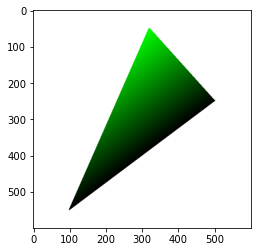

In [31]:
canvas1 = Canvas(600,600)
canvas2 = Canvas(600,600)

point1 = Point(-200, -250, h =0.0)
point2 = Point(200, 50, h =0.0)
point3 = Point(20, 250, h=1.0)

color = (0,0,0)
line_width = 2

canvas1.draw_filled_triangle(point1, point2, point3, (0,255,0), line_width)
canvas1.draw_wire_triangle(point1, point2, point3, color, line_width)

canvas2.draw_shaded_triangle(point1, point2, point3, (0,255,0), line_width)

plt.imshow(canvas2.img)